# An Enhanced Model

In this section, we will model with engineering many features by using one model for each store. We expect each store is independent of the others.

# Importing Packages

In [1]:
from datetime import date
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# Plotting import
import matplotlib.pyplot as plt
from plotting.time_series.style import plot_params  # plot style settings

In [3]:
from pathlib import Path
comp_dir = Path('../input/store-sales-time-series-forecasting')

In [4]:
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))

In [5]:
# Time Related Features
# Depending on your needs, you can turn on / off these features for time
def create_date_features(df):
    """Create date features for special days in a year."""
    df = df.to_timestamp()
    # df['month'] = df.index.month.astype("int8")
    # df['day_of_month'] = df.index.day.astype("int8")
    # df['day_of_year'] = df.index.dayofyear.astype("int16")
    # df["week_of_month"] = (
    #     df.date.apply(lambda d: (d.day - 1) // 7 + 1)
    # ).astype("int8")
    # df['week_of_year'] = (df.index.weekofyear).astype("int8")
    # df['day_of_week'] = (df.index.dayofweek + 1).astype("int8")
    # df['year'] = df.index.year.astype("int32")
    # df["is_wknd"] = (df.index.dayofweek // 5).astype("int8")
    # df["quarter"] = df.index.quarter.astype("int8")
    df["is_month_start"] = df.index.is_month_start.astype("int8")
    df["is_month_end"] = df.index.is_month_end.astype("int8")
    # df['is_quarter_start'] = df.index.is_quarter_start.astype("int8")
    # df['is_quarter_end'] = df.index.is_quarter_end.astype("int8")
    # df['is_year_start'] = df.index.is_year_start.astype("int8")
    # df['is_year_end'] = df.index.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    # df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    # df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    # df["season"] = pd.Series(
    #     np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    # ).astype("int8")
    df["wageday"] = np.where(
        df.index.is_month_end | (df.index.day == 15), 1, 0
    ).astype("int8")

    df = df.to_period("D")
    return df

# Importing Data

In [6]:
train_data = pd.read_csv(
    comp_dir / "train.csv", index_col="id", header=0, parse_dates=["date"]
)
stores_data = pd.read_csv(
    comp_dir / "stores.csv", index_col="store_nbr", header=0
)
store_nbr_id = stores_data.index.values

#  Preparing Data

## Holidays and Events

In [7]:
# Range of Date to Modeling
range_begin = "2017-03-15"
range_end = "2017-08-15"

In [8]:
holidays_events_data = pd.read_csv(
    comp_dir / "holidays_events.csv",
    index_col=None,
    header=0,
    parse_dates=["date"],
)
holidays_events_data = holidays_events_data.astype(
    {
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "category",
        "transferred": "bool",
    }
)
holidays_events_data = holidays_events_data.set_index("date").to_period("D")
holidays_events_data = holidays_events_data.loc[range_begin:]

In [9]:
# Remove transferred Holidays
# Query only transferred-related days
transferred_days = holidays_events_data.loc[
    (holidays_events_data.transferred == True), ["type", "description"]
]
new_transferal_days = holidays_events_data.loc[
    (holidays_events_data.type == "Transfer")
]
# Replace "Tranfer" type with "Holiday", replace descriptions back to original
clean_transferal_days = (
    pd.concat(
        [new_transferal_days.reset_index(), transferred_days.reset_index()],
        axis=1,
    )
    .iloc[:, [0, 2, 3, 7, 8]]
    .set_index("date")
)
# Remove transferred Holidays
holidays = holidays_events_data.loc[
    (holidays_events_data.transferred == False)
    & (holidays_events_data.type != "Transfer")
].drop("transferred", axis=1)
holidays = holidays.append(clean_transferal_days).sort_index()

In [10]:
# Clean special letters and numbers in `description`
holidays["description"] = (
    holidays["description"].str.replace("-", "").str.replace("+", "")
)
# `Additional` is also holiday
holidays["type"] = np.where(
    holidays["type"] == "Additional", "Holiday", holidays["type"]
)
# Bridge Holidays is also holiday
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(
    holidays["type"] == "Bridge", "Holiday", holidays["type"]
)

In [11]:
# Separate types of Holiday
# Remove Work Day type
work_day = holidays.loc[holidays.type == "Work Day"]
holidays = holidays.loc[holidays.type != "Work Day"]

events = (
    holidays.loc[holidays.type == "Event"]
    .drop(["type", "locale", "locale_name"], axis=1)
    .drop_duplicates()
)
events = events.rename({"description": "event_national"}, axis=1)
holidays = holidays.loc[holidays.type != "Event"].drop("type", axis=1)

In [12]:
holidays = (holidays.reset_index())
# .drop_duplicates(subset="date",keep='first').set_index('date')

holidays_National = (
    holidays.loc[holidays.locale == "National"]
    .loc[:, ["date", "description"]]
    .set_index("date")
)
holidays_Regional = (
    holidays.loc[holidays.locale == "Regional"]
    .loc[:, ["date", "locale_name", "description"]]
    .set_index("date")
)
holidays_Local = (
    holidays.loc[holidays.locale == "Local"]
    .loc[:, ["date", "locale_name", "description"]]
    .set_index("date")
)

# Rename columns
holidays_National = holidays_National.rename(
    {"description": "holiday_national"}, axis=1
).drop_duplicates()
holidays_Regional = holidays_Regional.rename(
    {"description": "holiday_state", "locale_name": "state"}, axis=1
).drop_duplicates()
holidays_Local = holidays_Local.rename(
    {"description": "holiday_city", "locale_name": "city"}, axis=1
).drop_duplicates()

## Train and Test Data

In [13]:
# Import Test Data
df_test = pd.read_csv(
    comp_dir / "test.csv",
    parse_dates=["date"],
    infer_datetime_format=True,
)
df_test = df_test.astype(
    {"store_nbr": "category", "family": "category", "onpromotion": "float32"}
)
df_test["date"] = df_test.date.dt.to_period("D")

# Append All data
train_data_clean = train_data.copy()
train_data_clean["date"] = train_data.date.dt.to_period("D")
train_data_clean = train_data_clean.append(df_test)
train_data_clean = train_data_clean.astype(
    {"family": "category", "sales": "float32", "onpromotion": "float32"}
)
train_data_clean["onpromotion"] = X_scaler.fit_transform(
    train_data_clean[["onpromotion"]]
).flatten()

## Merging Data

In [14]:
# Include Store information
all_data = pd.merge(train_data_clean, stores_data, on="store_nbr")
all_data = all_data.astype({"store_nbr": "category"})
# Add hoilidays
all_data = pd.merge(all_data, holidays_National, how="left", on="date")
all_data = pd.merge(all_data, events, how="left", on="date")
all_data = pd.merge(
    all_data, holidays_Regional, how="left", on=["date", "state"]
)
all_data = pd.merge(all_data, holidays_Local, how="left", on=["date", "city"])

## Manipulating Data

In [15]:
# Splitting Data
y_store = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
promos = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
holidays = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
X_dummies = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
Y_training = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
tmp2 = dict(iter(all_data.groupby("store_nbr")))
for store in store_nbr_id:
    # tmp = all_data.loc[all_data.store_nbr==store]
    tmp = tmp2[store]
    y_store[store] = tmp[["date", "family", "sales"]]

    promos[store] = tmp[["date", "family", "onpromotion"]].replace(
        {"0": np.nan, 0: np.nan}
    )
    promos[store].set_index("date")

    holidays[store] = tmp[
        ["date", "holiday_national", "holiday_state", "holiday_city"]
    ].drop_duplicates()
    holidays[store] = holidays[store].set_index("date")

# del all_data

In [16]:
# Manipulating Data
for store in store_nbr_id:
    y_store[store] = y_store[store].set_index(["family", "date"]).sort_index()
    y_store[store] = y_store[store].unstack("family")
    y_store[store] = y_store[store].fillna(0)

    promos[store] = (
        promos[store]
        .groupby(["date", "family"])
        .agg({"onpromotion": "mean"})
        .unstack("family")
        .dropna(how="all", axis=0)
        .fillna(0)
    )
    promos[store].columns = promos[store].columns.droplevel(level=0)

    Y_training[store] = y_store[store].loc[range_begin:range_end]
    X_dummies[store] = pd.get_dummies(holidays[store])
    if ~promos[store].empty:
        X_dummies[store] = pd.concat(
            [X_dummies[store], promos[store]], axis=1
        ).fillna(0)

# Engeneering features

In [17]:
# Creating Training Data
fourier = CalendarFourier(freq="M", order=4)  # Fourier(period=7, order=3)#
dp = np.empty(len(store_nbr_id) + 1, DeterministicProcess)
X_training = np.empty(len(store_nbr_id) + 1, pd.DataFrame)

for store in store_nbr_id:
    dp[store] = DeterministicProcess(
        index=Y_training[store].index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
        period=7,
    )
    X = dp[store].in_sample()
    X = create_date_features(X)
    X_training[store] = pd.concat(
        [X, X_dummies[store].loc[range_begin:range_end]], axis=1
    ).fillna(0)

# Building model

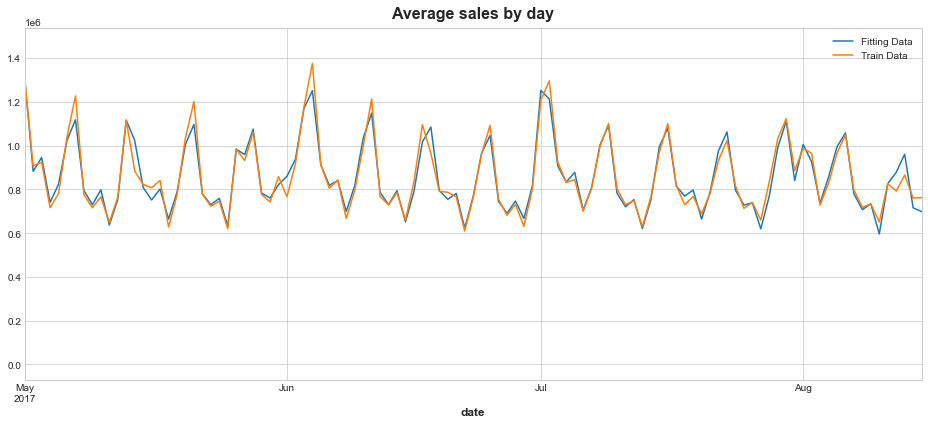

In [18]:
# Creating Model & Fitting
model = np.empty(len(store_nbr_id) + 1, LinearRegression)
y_pred = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
tmp = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
for store in store_nbr_id:
    model[store] = LinearRegression(fit_intercept=False)
    model[store].fit(
        X_training[store].reset_index().drop("date", axis=1), Y_training[store]
    )
    y_pred[store] = pd.DataFrame(
        model[store].predict(
            X_training[store].reset_index().drop("date", axis=1)
        ),
        index=X_training[store].index,
        columns=Y_training[store].columns,
    )
    tmp[store] = y_pred[store].stack(["family"])
    tmp[store]["store_nbr"] = store
    tmp[store]["store_nbr"] = tmp[store]["store_nbr"].astype(
        {"store_nbr": "category"}
    )
    tmp[store] = (
        tmp[store]
        .set_index("store_nbr", append=True)
        .reorder_levels(["store_nbr", "family", "date"])
    )

y_model = pd.concat(tmp[1:])

# Visualizing
figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
y_model.reset_index().groupby("date").agg(
    {"sales": "sum"}
).reset_index().set_index("date").plot(ax=ax)
train_data.groupby("date").agg({"sales": "sum"}).reset_index().set_index(
    "date"
).plot(ax=ax)
ax.legend(["Fitting Data", "Train Data"])
ax.set_xlim(date(2017, 5, 1))
ax.set_title("Average sales by day")
plt.show()

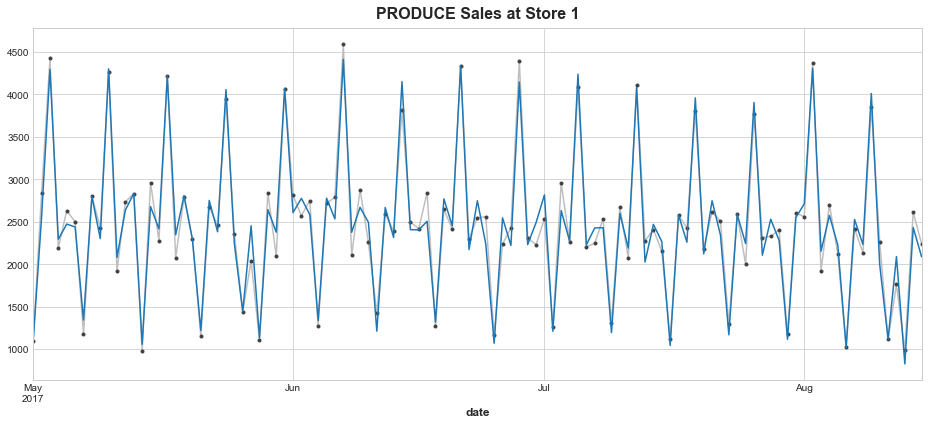

In [19]:
STORE_NBR = 1  # 1 - 54
FAMILY = "PRODUCE"
# to list all FAMILY
#   display(store_sales.index.get_level_values('family').unique())

figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
Y_training[STORE_NBR].loc(axis=1)["sales", FAMILY].plot(**plot_params, ax=ax)
y_pred[STORE_NBR].loc(axis=1)["sales", FAMILY].plot(ax=ax)
ax.set_xlim(date(2017, 5, 1))
ax.set_title(f"{FAMILY} Sales at Store {STORE_NBR}")
plt.show()

# Predict future sales

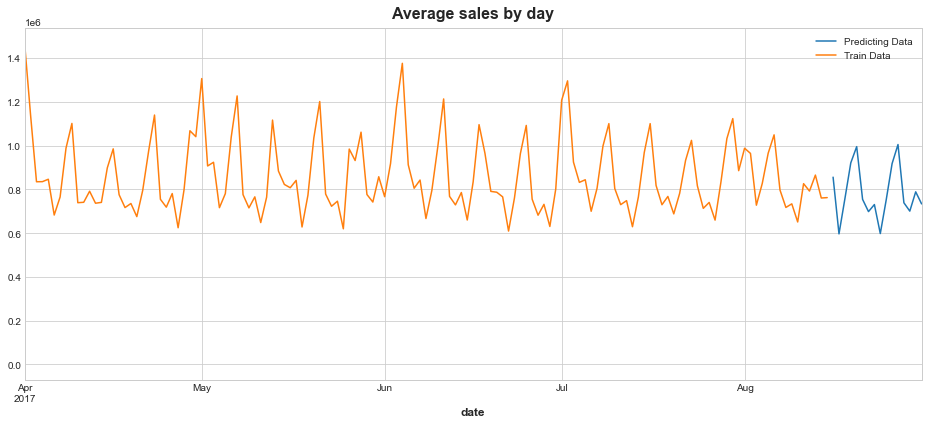

In [20]:
test_data = df_test.set_index(["store_nbr", "family", "date"]).sort_index()
# Creating Testing Features
X_test = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
y_pred = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
tmp = np.empty(len(store_nbr_id) + 1, pd.DataFrame)
y_submit = pd.DataFrame(index=test_data.index)
for store in store_nbr_id:
    X_test[store] = dp[store].out_of_sample(steps=16)
    X_test[store].index.name = "date"
    X_test[store] = create_date_features(X_test[store])
    X_test[store] = X_test[store].join(X_dummies[store]).fillna(0.0)
    # Modeling Predicting
    y_pred[store] = pd.DataFrame(
        model[store].predict(X_test[store]),
        index=X_test[store].index,
        columns=Y_training[store].columns,
    )
    tmp[store] = y_pred[store].stack(["family"])
    tmp[store]["store_nbr"] = store
    tmp[store]["store_nbr"] = tmp[store]["store_nbr"].astype(
        {"store_nbr": "category"}
    )
    tmp[store] = (
        tmp[store]
        .set_index("store_nbr", append=True)
        .reorder_levels(["store_nbr", "family", "date"])
    )

# Submission
y_submit = pd.concat(tmp[1:])
# y_submit = y_submit.join(test_data.id).reindex(columns=['id', 'sales'])
y_submit["sales"] = y_submit["sales"].clip(0.0)

# Visualizing
figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
y_submit.reset_index().groupby("date").agg(
    {"sales": "sum"}
).reset_index().set_index("date").plot(ax=ax)
train_data.groupby("date").agg({"sales": "sum"}).reset_index().set_index(
    "date"
).plot(ax=ax)
ax.legend(["Predicting Data", "Train Data"])
ax.set_xlim(date(2017, 4, 1))
ax.set_title("Average sales by day")
plt.show()

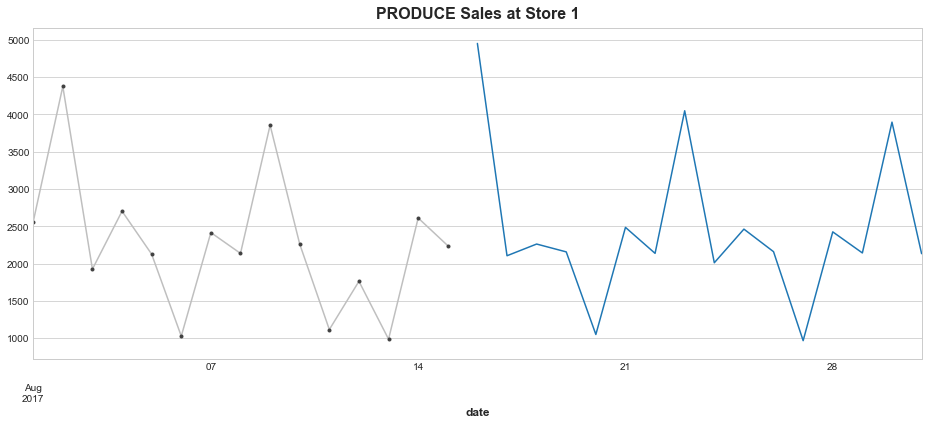

In [21]:
# Zoomed in
STORE_NBR = 1  # 1 - 54
FAMILY = "PRODUCE"
figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
Y_training[STORE_NBR].loc(axis=1)["sales", FAMILY].plot(**plot_params, ax=ax)
y_submit.loc[STORE_NBR, FAMILY].sales.plot(ax=ax)
ax.set_xlim(date(2017, 8, 1))
ax.set_title(f"{FAMILY} Sales at Store {STORE_NBR}")
plt.show()

```
# Submission
# Run this code to save predicted data to a csv file.
y_submit = (
    y_submit.reset_index()
    .set_index(["store_nbr", "family", "date"])
    .sort_index()
    .join(test_data)
    .reindex(columns=["id", "sales"])
)
y_submit.to_csv("submission.csv", index=False)
```